In [20]:
import tensorflow as tf
import numpy as np
import mavenn
import squid
import pandas as pd
import tqdm

In [22]:
class SquidWrapper(tf.keras.Model):
    """
    A small wrapper class to let CLIPNET predict on one-hot encoded sequences.
    """
    def __init__(self, base_model):
        super(SquidWrapper, self).__init__()
        self.base_model = base_model
        
    def call(self, inputs, training=False):
        # Multiply inputs by 2 before passing to the base model
        return self.base_model(inputs * 2, training=training)[1]
    
class QuantityEnsembler(tf.keras.Model):
    """
    A small wrapper class to average a bunch of models that have been passed through SquidWrapper.
    """
    def __init__(self, a_list_of_models):
        super(QuantityEnsembler, self).__init__()
        self.base_models = a_list_of_models
        
    def call(self, inputs, training=False):
        # Multiply inputs by 2 before passing to the base model
        return tf.expand_dims(tf.keras.layers.Average()([m(inputs) for m in self.base_models]), axis=-1)
    
def corr(x, y, pseudocount=1e-6):
    """
    Custom objective function that needs to be included when loading 
    CLIPNET instances.
    """
    mx = tf.math.reduce_mean(x)
    my = tf.math.reduce_mean(y)
    xm, ym = x - mx, y - my
    num = tf.math.reduce_mean(tf.multiply(xm, ym))
    den = tf.math.reduce_std(xm) * tf.math.reduce_std(ym) + pseudocount
    r = tf.math.maximum(tf.math.minimum(num / den, 1), -1)
    return r

In [23]:
import os
model_path = "/home/adamyhe/github/clipnet/clipnet_models"
model_list = os.listdir(model_path)
print(model_list)

['fold_1.h5', 'fold_4.h5', 'fold_5.h5', 'fold_8.h5', 'fold_7.h5', 'fold_2.h5', 'fold_6.h5', 'fold_3.h5', 'fold_9.h5']


In [24]:
# Load and wrap models
models = QuantityEnsembler(
    [
        SquidWrapper(tf.keras.models.load_model(os.path.join(model_path, m), custom_objects={"corr": corr}))
        for m in tqdm.tqdm(model_list)
    ]
)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:14<00:00,  1.56s/it]


In [25]:
# Sequence of the IRF4 promoter in hg38. 2114 sequence taken for compatibility with
# ProCapNet and the PyTorch implementation of CLIPNET. We analyze the TF version
# of CLIPNET here, so we trim to just the middle 1kb
# >irf4_prom range=chr6:390663-392776 5'pad=0 3'pad=0 strand=+ repeatMasking=none
sequence = "GCTCACTGCAACTTCAGCCTCCCGGGTTCAAGCGATTCTCGTGGCTCGTCCTCTCAAGTAGCTGGGGCCACGCCCGGCTAATTTTTGTATTTTTAGTAGAGATGGGGTTTCACCGTGTTGGCCAGGCTGGTCTCGAACTCCTGACCTCAGGCGATCCACCGCCTCGGCCTCCCAAAGTGCTGGGATTACAGGCTTGAGCCACAGCGCCTGGCCTATTTTGGGCTTTTATACCCCACTGGTAAACTGCTTTCCTCCAGGTTGAGGTTAAAACGACATCATTTTAAGGTGAACTGAAGTCTGGAAGTGATTAAGCACTTGGATCCTTAGGGAGCCTCTCCCCGCCCCCATCTCTTTCATGCTAAGATAATTAAAACTTCGGGGCCGGGGCATTGTCTGAGTCACTTCAATTCACCAGCCTAATAGATGCAAAAGGATGTAAGCATGTCAGACACGCAGAGACAGTATTTGAATCAAGCTTAATAGCTCAAGGGAGCTGGGCCATTTCCTATTTTCTTTTTAGTGAGTGCGATGTTCTCTAAACACCGCGGAGAGGCAGGGTTCCCGGTGATGGCCTTGCCGAGGGTGCTCCCGCAACCTCCACCTCCAGTTCTCTTTGGACCATTCCTCCGTCTTCCGTTACACGCTCTGCAAAGCGAAGTCCCCTTCGCACCAGATTCCCGCTACTACACGCCCCCCATTTCCCGCCCTGGCCACATCGCTGCAGTTTAGTGATTGACTGGCCTCCTGAGGTCCTGGCGCAAAGGCGAGATTCGCATTTCGCACCTCGCCCTTCGCGGGAAACGGCCCCAGTGACAGTCCCCGAAGCGGCGCGCGCCCGGCTGGAGGTGCGCTCTCCGGGCGCGGCGCGCGGAGGGTCGCCAAGGGCGCGGGAACCCCACCCCGGCCGCGGCAGCCCCCAGCCTTCACGCCGGCCCTGAGGCTCGCCCGCCCGGCCGGCCCCGGCTCTCGGCTTGCAAAGTCCCTCTCCCCAGTCCAACCCCCGGCCCCCACAGGCCTCGGCGCCCCGCCCCGCCCCAGGCCCCGCCCCAGAGAGTTCTATAAAGTTCCTCTTTCCCACCTCGCACTCTCAGTTTCACCGCTCGATCTTGGGACCCACCGCTGCCCTCAGCTCCGAGTCCAGGGCGAGGTAAGGGCTGGAGTCGGGCAGGAGGAGGGGTGTGAGGCTGATACCAGAGAGGACCCGGAGCGCGAACCAGAGGTTCGACCTCCAGGGCAGCGCAGGGTACCCCGGCTTCGGAGCGGGAAGGGAGCGCGCCCCGTCCTGGAGCTCCGACTCCCACCCCATCTGCGCTGAGCCGGAGGCGCTGGTTTGGGCTCCAAGGCCCGCCTCCTTGGCTCTGCCCGAGCCTCCCCGCCTGCCCTCCGCGCTCCTGCGACGGGGTCGCCACAAGCTGGACGGGATGAGCTAACCGGACTGTCGGGGCCCCAGGAGTGGCTGAGGCGGGGCCGTCCAAGGCACCCACACAAGACGGCACAACTGCCTGCGAGAAACAGGCCCGGCCCTGTGGACCCCAATCCGAGGCTCCTTCCCCTGCTCTTCGTTCCTAAGGGGCCCAAGCTCACGGCGGCCTCCGGCGCGGTGCTCACCCGCTGGCGCAGGAGGAGGAGGAGCTCCACATTTGGGTCGCTCCGAGCCTTGCGTGCGGTGGCCTAGCCGGCCTGGCGCGGTCCCTGCCTCCCAGGCTCCGCAGCTGTCGTCGCCCTCTCCCGCGCCCTCCCCGCCTCCGCTCTCCCGGGCCTGCTCCGGGGTCCGGCGGACGCTCTGCGCGCGGAATCCCCCGTACTGGGGCTGCAGCCCCCGCGTCTGCGCCACTTGTCGTTTGCAGAGCCCACTTAGTGCGCGCTAGCTGGGCAGGGATAGGGGTCCTATTCGGGGCGAAGGGTCTGGATGCGAGCAGAGAAAGCGGAGGGTGGAGGAACCCGGGGCTGCGCCCCTGGAACGCCCGGCCGCAGGCGAGGTCCTCCGCGCGTGGAGGCCGCCAGGGGAGTGGAAACTGACAGAGTCGCGGGGAAGGGGCGAGAAGCGGGTTGGGAGTGAGCGAAGGCAAGCGAGAGCTGCGAGTGAGTGCGGAAGGAGGGCCAGGAGGGGTGGC"
seq = sequence[(len(sequence) - 1000) // 2 : -((len(sequence) - 1000) // 2)]
alphabet = ["A", "C", "G", "T"]
x = squid.utils.seq2oh(seq, alphabet)

In [26]:
# define mutagenesis window for sequence
start_position = 460
stop_position = 540

seq_length = x.shape[0]
mut_window = [start_position, stop_position]

In [27]:
# set up predictor class for in silico MAVE
pred_generator = squid.predictor.ProfilePredictor(
    pred_fun=models,
    batch_size=512,
    reduce_fun=squid.predictor.profile_sum,
)

In [28]:
# set up mutagenizer class for in silico MAVE
mut_generator = squid.mutagenizer.RandomMutagenesis(mut_rate=0.1, uniform=False)

# generate in silico MAVE
mave = squid.mave.InSilicoMAVE(mut_generator, pred_generator, seq_length, mut_window=mut_window)
x_mut, y_mut = mave.generate(x, num_sim=100_000)
tf.keras.backend.clear_session()


Building in silico MAVE...


Inference: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 195/195 [01:18<00:00,  2.50it/s]


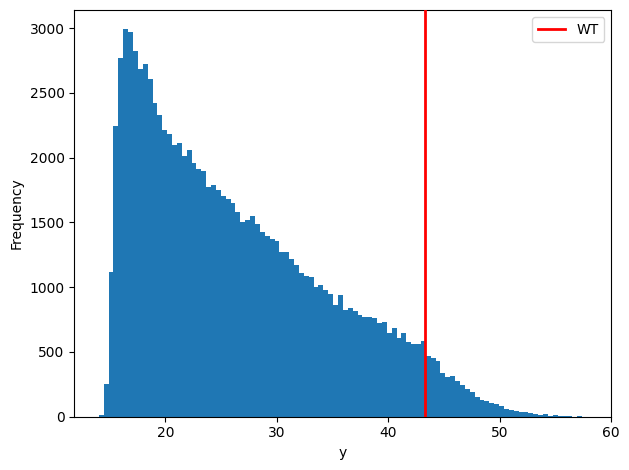

In [29]:
# plot histogram of transformed deepnet predictions
fig = squid.impress.plot_y_hist(y_mut)

In [30]:
# delimit sequence to region of interest (required for pairwise computational constraints)
x_mut_trim = x_mut[:,mut_window[0]:mut_window[1],:]

In [35]:
# choose surrogate model type
gpmap = 'pairwise' #{'additive', 'pairwise' if MAVE-NN}

# MAVE-NN model with GE nonlinearity
surrogate_model = squid.surrogate_zoo.SurrogateMAVENN(
    x_mut_trim.shape,
    num_tasks=y_mut.shape[1],
    gpmap=gpmap,
    regression_type='GE',
    linearity='linear',
    noise='SkewedT',
    noise_order=2,
    reg_strength=0.1,
    alphabet=alphabet,
    deduplicate=True,
    gpu=True
)

In [36]:
# train surrogate model
surrogate, mave_df = surrogate_model.train(
    x_mut_trim,
    y_mut,
    learning_rate=5e-4,
    epochs=500,
    batch_size=100,
    early_stopping=True,
    patience=25,
    restore_best_weights=True,
    save_dir=None,
    verbose=1
)

# retrieve model parameters
params = surrogate_model.get_params(gauge='empirical')
tf.keras.backend.clear_session()

  Creating sequence dataframe...

               y                                                  x
0      43.258690  CGGCGCCCCGCCCCGCCCCAGGCCCCGCCCCAGAGAGTTCTATAAA...
1      42.007744  CGGCGCCCCGCCCCGCCCCAGGCCCCGCCCCATAGAGTTCTATAAA...
2      26.269514  CGGCGCCCCGCCCAGCTCCAGTCCCTGCCCCAGAGAGTTCTATAAA...
3      30.678080  CGCCGCCCCGCCCCGCCCCAGTTCGCGCCCCAGAGAGTTCTATATA...
4      26.093708  CAGCGCCCCGGCCCGCCTACGGCCCCGCCCGAGAGAGTTCTATAAA...
...          ...                                                ...
99995  20.005659  CGTCGCCCCGCCCCGCCCCAGGCCCCGCACCAGCGACTTCTATAAA...
99996  23.314400  CGGCGCCCCGGCCCGCGCCAGGCCCCGCCCCACAGAGTTCTTTATA...
99997  22.394377  CGGCGCCCCGCCCCGCCCCAGGCCCCGCCCGAGAGAGGGCTATGCA...
99998  17.827415  CGGCGCCCCGCTCCGCCCCAGGCCTCGCCACAGAGAGTTCTATGGA...
99999  22.500450  CGCCGCCCTGCCTCGCCCCTGGCCCGGCCCCATAGAGTTCTTTAAA...

[100000 rows x 2 columns]
Training set   :   59,851 observations (  59.95%)
Validation set :   19,800 observations (  19.83%)
Test set       :   20,1

  7%|███████████▏                                                                                                                                                   | 35/500 [02:54<38:36,  4.98s/epoch, loss=-16.8, I_var=2.04, val_loss=55.1, val_I_var=1]

Training time: 174.6 seconds


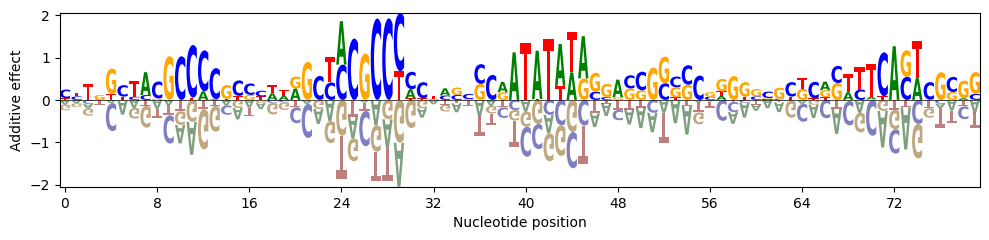

In [37]:
# plot additive logo
fig = squid.impress.plot_additive_logo(params[1], center=True, view_window=None, alphabet=alphabet, fig_size=[10,2.5])
fig.savefig("irf4_prom_quantity_linear_additive.pdf")

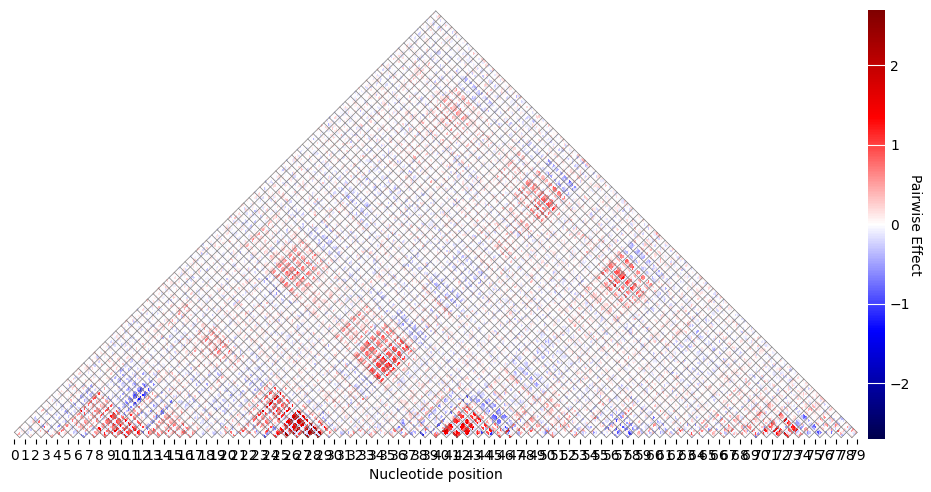

In [38]:
# plot pairwise matrix
fig = squid.impress.plot_pairwise_matrix(params[2], view_window=None, alphabet=alphabet)
fig.savefig("irf4_prom_quantity_linear_pairwise.pdf")

In [39]:
np.savez_compressed("irf4_prom_quantity_linear.npz", *params)